In [389]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import tensorflow as tf
import tensorflow_data_validation as tfdv
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix,r2_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [390]:
df = pd.read_csv("./student_lifestyle_dataset.csv")
df.head()

,Student_ID,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
0,1,6.9,3.8,8.7,2.8,1.8,2.99,Moderate
1,2,5.3,3.5,8.0,4.2,3.0,2.75,Low
2,3,5.1,3.9,9.2,1.2,4.6,2.67,Low
3,4,6.5,2.1,7.2,1.7,6.5,2.88,Moderate
4,5,8.1,0.6,6.5,2.2,6.6,3.51,High


In [391]:
df["Stress_Level"].value_counts()

High        1029
Moderate     674
Low          297
Name: Stress_Level, dtype: int64

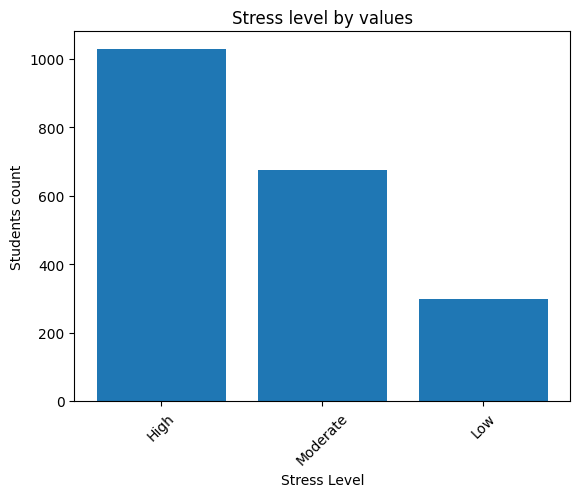

In [392]:
class_counts = df["Stress_Level"].value_counts()
plt.bar(class_counts.index, class_counts.values)
plt.title("Stress level by values")
plt.xlabel("Stress Level")
plt.ylabel("Students count")
plt.xticks(rotation=45)
plt.show()

In [393]:
le = LabelEncoder()

df["Stress_Level"] = le.fit_transform(df["Stress_Level"])

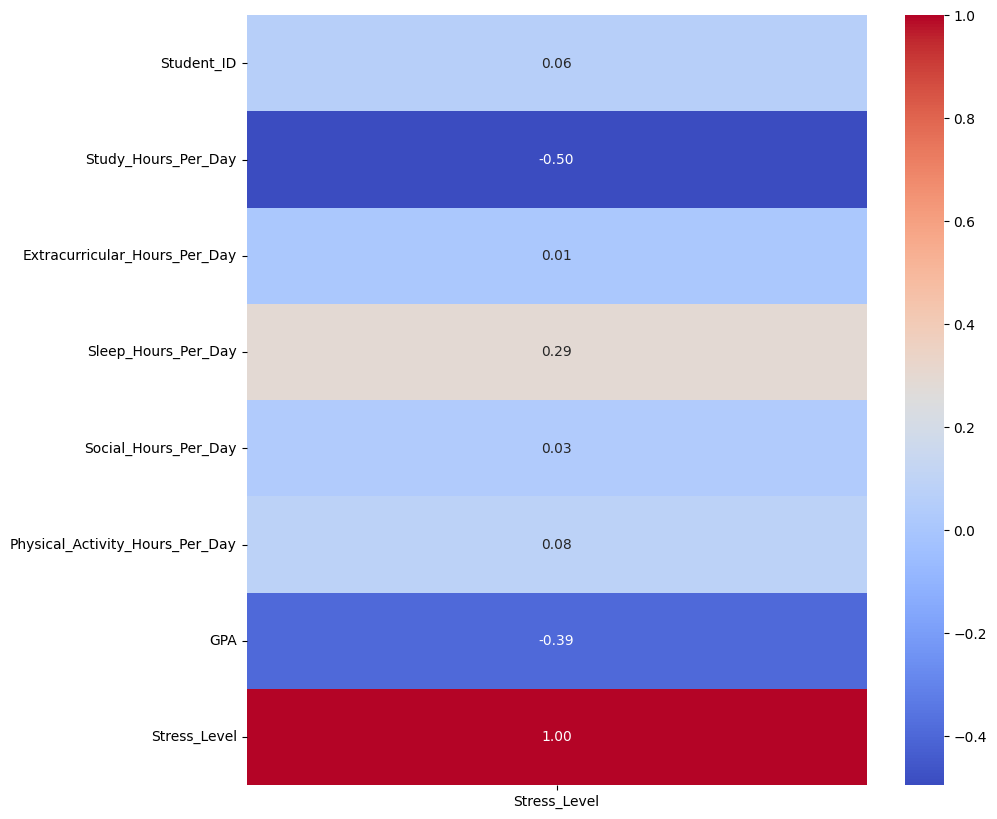

In [394]:
corr = df.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr[["Stress_Level"]], annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

In [395]:
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))

threshold = 3

outliers = np.where(z_scores > threshold)

print("Indices of outliers:", outliers)

Indices of outliers: (array([  62,  171,  784, 1174], dtype=int64), array([5, 5, 5, 5], dtype=int64))


In [396]:
outlier_rows = df.iloc[outliers[0]]
outlier_rows

,Student_ID,Study_Hours_Per_Day,Extracurricular_Hours_Per_Day,Sleep_Hours_Per_Day,Social_Hours_Per_Day,Physical_Activity_Hours_Per_Day,GPA,Stress_Level
62,63,5.1,0.5,5.2,0.2,13.0,2.85,0
171,172,5.1,0.3,6.0,0.2,12.4,2.70,1
784,785,5.1,0.3,6.3,0.2,12.1,2.55,1
1174,1175,5.3,0.3,5.9,0.2,12.3,2.97,0


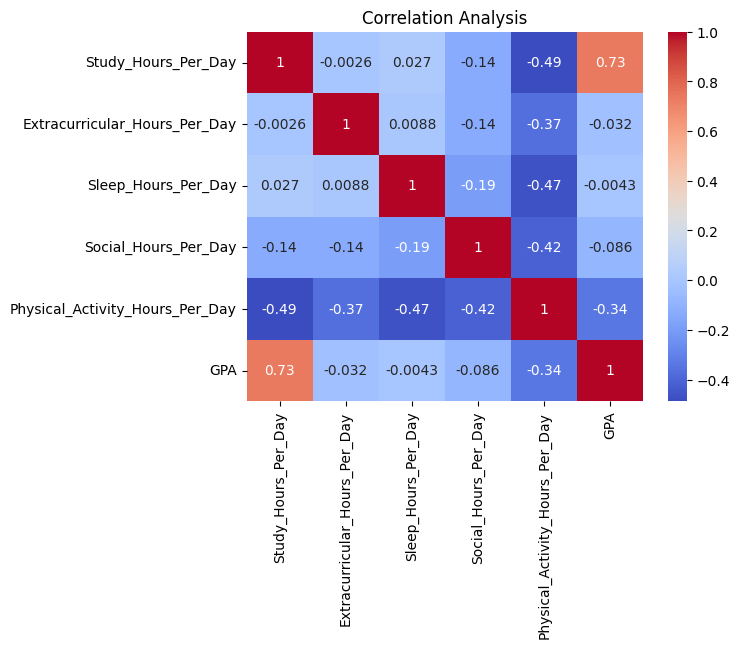

In [397]:
second = df[
    [
        "Study_Hours_Per_Day",
        "Extracurricular_Hours_Per_Day",
        "Sleep_Hours_Per_Day",
        "Social_Hours_Per_Day",
        "Physical_Activity_Hours_Per_Day",
        "GPA",
        "Stress_Level",
    ]
]


def indicator(value):
    if value == "High":
        return 3
    if value == "Moderate":
        return 2
    if value == "Low":
        return 1


second["Stress_indicator"] = df["Stress_Level"].map(indicator)

second.drop(columns=["Stress_Level"], inplace=True)
sns.heatmap(second.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Analysis")
plt.show()

### Insights:

- Согласно heatmap, социальная и физическая активность сокращают время на учебу. Количество учебных часов и средний балл положительно коррелируют. Уровень учебы повышается вместе с уровнем стресса.
- Физическая и социальная активность отрицательно коррелируют с количеством внеклассных занятий. что хорошо в других местах. Проводить качественные исследования предпочтительнее, чем тратить время на социальные сети.
- Стресс и продолжительность сна отрицательно коррелируют. Следовательно, больше сна снижает стресс.
- Физическая активность полезна, но она негативно влияет на стресс. независимо от того, играете вы или нет. Вы испытываете стресс.


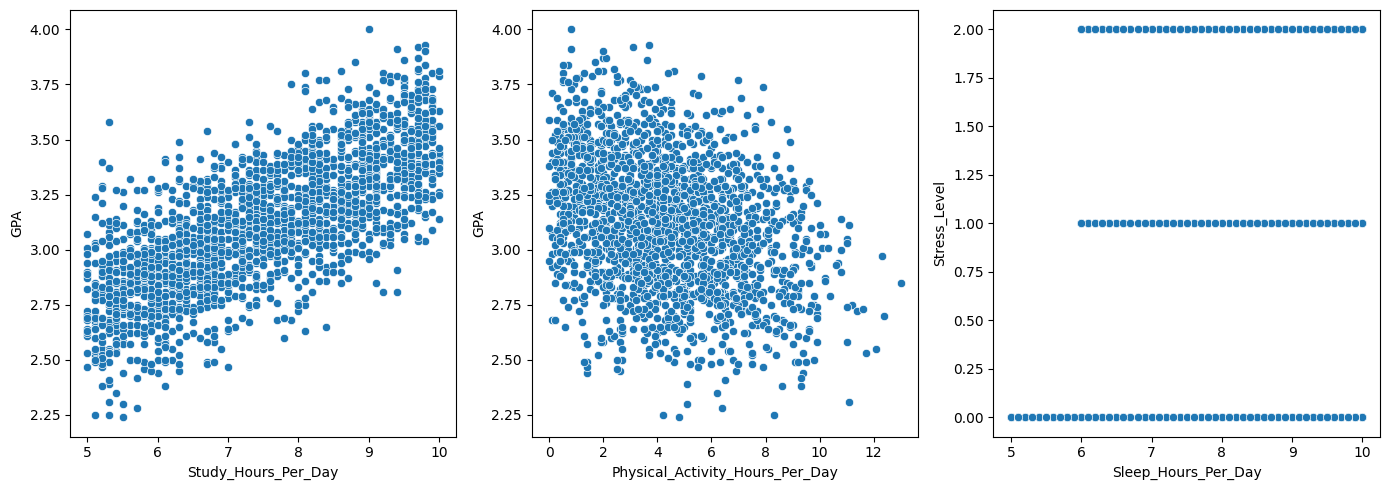

In [398]:
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
sns.scatterplot(x=df["Study_Hours_Per_Day"], y=df["GPA"])

plt.subplot(1, 3, 2)
sns.scatterplot(x=df["Physical_Activity_Hours_Per_Day"], y=df["GPA"])

plt.subplot(1, 3, 3)
sns.scatterplot(x=df["Sleep_Hours_Per_Day"], y=df["Stress_Level"])


plt.tight_layout()
plt.show()

- Согласно первому графику, средний балл увеличивается с увеличением количества учебных часов.

- Второй график демонстрирует положительную связь между 0-4 часами физической активности и успешными результатами в учебе. Кроме того, учащиеся, которые занимаются спортом более шести часов, имеют очень низкий средний балл.

- На третьем графике показано, что сон продолжительностью более шести часов приводит к стрессу средней или низкой степени. Все учащиеся, которые спят менее шести часов, находятся в состоянии стресса. Следовательно, 6:30 - это пороговое значение для засыпания.

In [399]:
df.drop("Student_ID", axis=1, inplace=True)
X, TEST = train_test_split(df, test_size=0.2, random_state=65675)
TEST, VAL = train_test_split(TEST, test_size=0.5, random_state=65675)

In [400]:
train_stats = tfdv.generate_statistics_from_dataframe(X)
test_stats = tfdv.generate_statistics_from_dataframe(TEST)
val_stats = tfdv.generate_statistics_from_dataframe(VAL)

tfdv.visualize_statistics(lhs_statistics=test_stats, rhs_statistics=train_stats,
                          lhs_name='TEST_DATASET', rhs_name='TRAIN_DATASET')

In [401]:
schema = tfdv.infer_schema(train_stats)
anomalies = tfdv.validate_statistics(statistics=test_stats, schema=schema)
tfdv.display_anomalies(anomalies)

In [402]:
schema = tfdv.infer_schema(train_stats)
anomalies = tfdv.validate_statistics(statistics=val_stats, schema=schema)
tfdv.display_anomalies(anomalies)

In [403]:
Stress_Level = tfdv.get_feature(schema, "Stress_Level")
Stress_Level.skew_comparator.infinity_norm.threshold = 0.01


skew_anomalies = tfdv.validate_statistics(
    train_stats, schema, previous_statistics=test_stats, serving_statistics=val_stats
)

tfdv.display_anomalies(skew_anomalies)

# Model

In [404]:
X_train = X.drop("Stress_Level", axis=1)
y_train = X["Stress_Level"]
X_test = TEST.drop("Stress_Level", axis=1)
y_test = TEST["Stress_Level"]
X_val = VAL.drop("Stress_Level", axis=1)
y_val = VAL["Stress_Level"]

In [405]:
enc = OneHotEncoder()
y_train_label = enc.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_test_label = enc.transform(y_test.values.reshape(-1, 1)).toarray()
y_val_label = enc.transform(y_val.values.reshape(-1, 1)).toarray()

In [406]:
print("Classes: ", le.classes_)
print("Categories: ", enc.categories_)

Classes:  ['High' 'Low' 'Moderate']
Categories:  [array([0, 1, 2])]


In [407]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train_label))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test_label))
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val_label))

In [408]:
model = keras.Sequential(
    [
        keras.layers.Dense(256, activation="relu", input_shape=(X_train.shape[1],)),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(y_train_label.shape[1], activation="softmax"),
    ]
)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()


callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="b_model.keras", monitor="val_accuracy", save_best_only=True
    ),
]

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 256)            │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,139 (168.51 KB)

 Trainable params: 43,139 (168.51 KB)

 Non-trainable params: 0 (0.00 B)

In [409]:
train_data_ep = train_data.map(
    lambda x, y: (tf.reshape(x, (1, X_train.shape[1])),
                  tf.reshape(y, (1, y_train_label.shape[1]))),
).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_data_ep = val_data.map(
    lambda x, y: (tf.reshape(x, (1, X_val.shape[1])),
                  tf.reshape(y, (1, y_train_label.shape[1])))
).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [410]:
history = model.fit(train_data_ep, epochs=20, validation_data=val_data_ep, callbacks=callbacks)

Epoch 1/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 2s 786us/step - accuracy: 0.7320 - loss: 0.6021 - val_accuracy: 0.9000 - val_loss: 0.2659
Epoch 2/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 1s 735us/step - accuracy: 0.8665 - loss: 0.3100 - val_accuracy: 0.9150 - val_loss: 0.1871
Epoch 3/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - accuracy: 0.8897 - loss: 0.2590 - val_accuracy: 0.9300 - val_loss: 0.1454
Epoch 4/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 1s 733us/step - accuracy: 0.9075 - loss: 0.2303 - val_accuracy: 0.9450 - val_loss: 0.1095
Epoch 5/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step - accuracy: 0.9140 - loss: 0.2085 - val_accuracy: 0.9400 - val_loss: 0.1011
Epoch 6/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 1s 704us/step - accuracy: 0.9155 - loss: 0.2008 - val_accuracy: 0.9350 - val_loss: 0.1188
Epoch 7/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - accuracy: 0.9273 - loss: 0.1831 - val_accuracy: 0.9450 - val_loss: 0.1020
Epoch 8/20
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step - accuracy: 0.9228 -

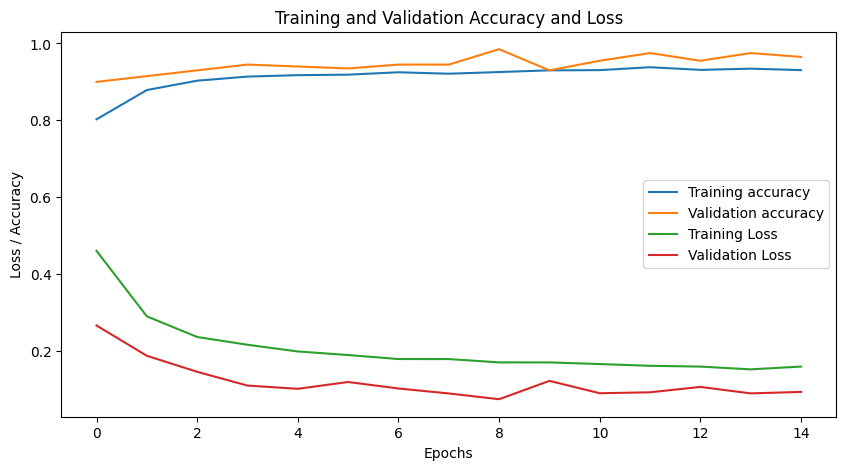

In [411]:
plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy")
plt.title("Training and Validation Accuracy and Loss")
plt.legend()
plt.show()

In [412]:
predictions = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [413]:
predictions = np.argmax(predictions, axis=1)

In [414]:

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=le.classes_))

Accuracy: 0.92

Classification Report:
              precision    recall  f1-score   support

        High       0.98      0.90      0.94       109
         Low       0.89      0.96      0.93        26
    Moderate       0.83      0.92      0.88        65

    accuracy                           0.92       200
   macro avg       0.90      0.93      0.91       200
weighted avg       0.92      0.92      0.92       200



In [415]:
r2_score(y_test, predictions)

0.6592015579357351

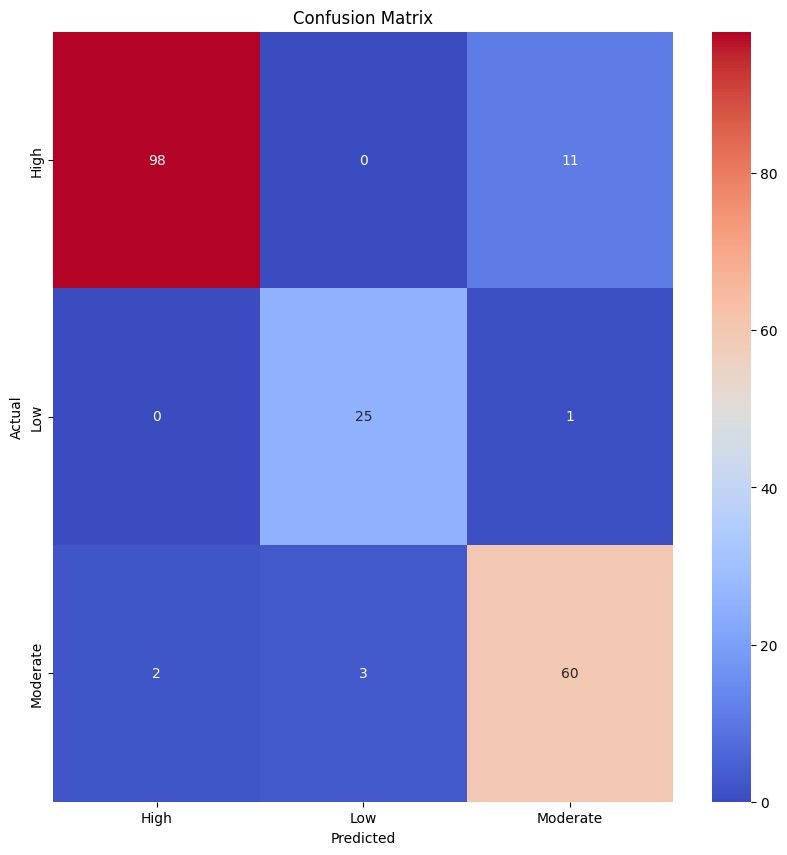

In [416]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(10, 10))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=le.classes_, yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [417]:

model = LogisticRegression(multi_class="ovr", max_iter=200, solver="liblinear", random_state=65675)
model.fit(X_train, y_train)

LogisticRegression(max_iter=200, multi_class='ovr', random_state=65675,
                   solver='liblinear')

In [418]:
predictions = model.predict(X_test)

In [419]:
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, predictions))

Accuracy: 0.82

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.94      0.86       109
           1       0.86      0.96      0.91        26
           2       0.90      0.55      0.69        65

    accuracy                           0.82       200
   macro avg       0.85      0.82      0.82       200
weighted avg       0.83      0.82      0.81       200

